<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/CycleGANv2020_ResNetCompositeBufferModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CycleGAN
> This is the CycleGAN implementation as detailed by tensorflow Core Tutorials [CycleGAN](https://www.tensorflow.org/tutorials/generative/cyclegan) to do image segemntation on the cityscape data as detailed by tensorflow datasets [datasets](https://www.tensorflow.org/datasets/catalog/cycle_gan). Additionally, the following sources were copy and pasted (I mean implemented 🤪): 
> 1.   [tf.data.Dataset](https://www.tensorflow.org/tutorials/load_data/images)
> 2.   [encode tensor into jpg image](https://stackoverflow.com/questions/40320271/how-do-we-use-tf-image-encode-jpeg-to-write-out-an-image-in-tensorflow)
> 3.   [downloading folders from Google Colab](https://stackoverflow.com/questions/50453428/how-do-i-download-multiple-files-or-an-entire-folder-from-google-colab)




In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
from keras.models import Input
import pathlib
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from numpy import asarray
AUTOTUNE = tf.data.AUTOTUNE
# importing various Keras modules for resnet implementation
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.initializers import RandomNormal
from keras.layers import Concatenate
from tensorflow_addons.layers import InstanceNormalization
import numpy as np
import copy

# Loading CityScape Dataset, Formatting into CycleGan Format, and Preprocesing 

In [ ]:
# dataset_name = "cityscapes"
# _URL = f"http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz"
# path_to_zip = tf.keras.utils.get_file(fname=f"{dataset_name}.tar.gz", 
#                                       origin = _URL, 
#                                       extract = True)
# path_to_zip = pathlib.Path(path_to_zip)
# PATH = path_to_zip.parent/dataset_name

In [ ]:
# list(PATH.parent.iterdir())

In [ ]:
!tar -xf '/content/drive/MyDrive/Datasets/cityscapes.tar.gz'

In [ ]:
x = sorted(os.listdir('/content/cityscapes/train/'))
y = sorted(os.listdir('/content/cityscapes/val/'))

In [ ]:
def write_jpeg(data, filepath):
    g = tf.Graph()
    with g.as_default():
        data_t = tf.compat.v1.placeholder(dtype=tf.uint8)
        op = tf.image.encode_jpeg(data_t, format='rgb', quality=100)
        init = tf.compat.v1.initialize_all_variables()

    with tf.compat.v1.Session(graph=g) as sess:
        sess.run(init)
        data_np = sess.run(op, feed_dict={ data_t: data })

    with open(filepath, 'wb') as fd:
        fd.write(data_np)

def process_cityscapes(image_file, output_dir, phase, number):
  save_phase = 'test' if phase == 'val' else 'train'
  savedir = os.path.join(output_dir, save_phase)
    
  image = Image.open(image_file)
  image = asarray(image)
  width = image.shape[1] # get width of image
  width = width//2 # set width to 256
  
  # split the images to create X and Y
  semantic_seg_image = image[:, width:, :]
  driving_image = image[:, :width, :]
  
  savepath = os.path.join(savedir + 'A', f"{number}")
  write_jpeg(semantic_seg_image, savepath)
  savepath = os.path.join(savedir + 'B', f"{number}")
  write_jpeg(driving_image, savepath)

def make_directory(output_dir, phase):
  save_phase = 'test' if phase == 'val' else 'train'
  savedir = os.path.join(output_dir, save_phase)
  os.makedirs(savedir, exist_ok=True)
  os.makedirs(savedir + 'A', exist_ok=True)
  os.makedirs(savedir + 'B', exist_ok=True)
  print("Directory structure prepared at %s" % output_dir)

make_directory('/content/datasets/cityscapes', 'train')
for i in x:
  process_cityscapes(f"/content/cityscapes/train/{i}", '/content/datasets/cityscapes', 'train', i)
make_directory('/content/datasets/cityscapes', 'val')
for i in y:
  process_cityscapes(f"/content/cityscapes/val/{i}", '/content/datasets/cityscapes', 'val', i)

Directory structure prepared at /content/datasets/cityscapes
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Directory structure prepared at /content/datasets/cityscapes


In [ ]:
TRAIN_BUFFER_SIZE = 3000
TEST_BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = image[:IMG_HEIGHT, :IMG_WIDTH, :3]
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image


def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(photos, segmentations):
  # Load the raw data from the file as a string
  img = tf.io.read_file(photos)
  img = decode_img(img)
  img = random_crop(img)
  img = normalize(img)
  seg = tf.io.read_file(segmentations)
  seg = decode_img(seg)
  seg = random_crop(seg)
  seg = normalize(seg)
  return img, seg


In [ ]:
seg_list = []
photo_list = []
for i in sorted(os.listdir("/content/datasets/cityscapes/trainA/")):
  seg_list.append(os.path.join("/content/datasets/cityscapes/trainA/", i))
for i in sorted(os.listdir("/content/datasets/cityscapes/trainB/")):
  photo_list.append(os.path.join("/content/datasets/cityscapes/trainB/", i))

segmentations = tf.constant(seg_list)
photos =   tf.constant(photo_list)

train_ds = tf.data.Dataset.from_tensor_slices((photos, segmentations))
train_ds = train_ds.cache().map(process_path).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)

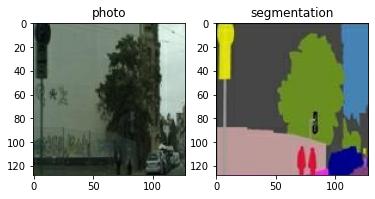

In [ ]:
for i in train_ds.take(1):
  plt.subplot(121)
  plt.title('photo')
  plt.imshow(i[0][0] * 0.5 + 0.5)
  plt.subplot(122)
  plt.title('segmentation')
  plt.imshow(i[1][0] * 0.5 + 0.5)

In [ ]:
sample_photo, sample_seg = next(iter(train_ds))

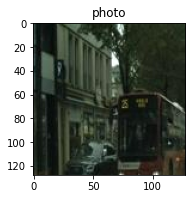

In [ ]:
plt.subplot(121)
plt.title('photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

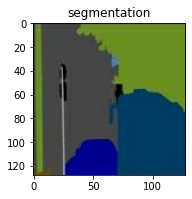

In [ ]:
plt.subplot(122)
plt.title('segmentation')
plt.imshow(sample_seg[0] * 0.5 + 0.5)

# Discriminator Portion

> For discriminator networks, we use 70 × 70 PatchGAN [22]. Let Ck denote a
4 × 4 Convolution-InstanceNorm-LeakyReLU layer with k
filters and stride 2. After the last layer, we apply a convolution to produce a 1-dimensional output. We do not use
InstanceNorm for the first C64 layer. We use leaky ReLUs
with a slope of 0.2. The discriminator architecture is:

> C64-C128-C256-C512



This implementation uses the discriminator implementation as detailed by [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/) which is a partial implementation of the orginial generator architecutre from [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593v1.pdf)

[22] P. Isola, J.-Y. Zhu, T. Zhou, and A. A. Efros. Imageto-image translation with conditional adversarial networks. In CVPR, 2017

In [ ]:
def define_discriminator(image_shape=(256,256,3)):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # source image input
  in_image = Input(shape=image_shape)
  # C64
  d = Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
  d = LeakyReLU(alpha=0.2)(d)
  # C128
  d = Conv2D(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C256
  d = Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # C512
  d = Conv2D(filters=512, kernel_size=(4,4), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # second last output layer
  d = Conv2D(filters=512, kernel_size=(4,4), padding='same', kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)
  # patch output
  patch_out = Conv2D(filters=1, kernel_size=(4,4), padding='same', kernel_initializer=init)(d)
  # define model
  model = Model(in_image, patch_out)
  # return model
  return model

# 9-block Resnet Generator Portion

> We adapt our architectures from Johnson et al. [23]. We use 6 residual blocks for 128 × 128 training images, and 9 residual blocks for 256 ×
256 or higher-resolution training images...let c7s1-k denote a 7×7 Convolution-InstanceNormReLU layer with k filters and stride 1. dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and
stride 2. Reflection padding was used to reduce artifacts.
Rk denotes a residual block that contains two 3 × 3 convolutional layers with the same number of filters on both
layer. uk denotes a 3 × 3 fractional-strided-ConvolutionInstanceNorm-ReLU layer with k filters and stride 1/2.

> The network with 6 residual blocks consists of:

> c7s1-64,d128,d256,R256,R256,R256,
R256,R256,R256,u128,u64,c7s1-3

> The network with 9 residual blocks consists of:

> c7s1-64,d128,d256,R256,R256,R256,
R256,R256,R256,R256,R256,R256,u128
u64,c7s1-3




This implementation uses the resnet generator implementation as detailed by [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/) which is a partial implementation of the orginial generator architecutre from [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593v1.pdf) found in the 2020 preprint version. The only difference is:  
*   The use of same padding rather then [reflective/mirror padding](https://www.youtube.com/watch?v=h0c0Tt9wsLg)

  

[23] J. Johnson, A. Alahi, and L. Fei-Fei. Perceptual losses
for real-time style transfer and super-resolution. In
ECCV, pages 694–711. Springer, 2016










In [ ]:
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

# Generator construction
def define_generator(image_shape=(256,256,3), n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# Composite Portion

This implementation of the composite model comes from [Jason Brownlee](https://machinelearningmastery.com/how-to-develop-cyclegan-models-from-scratch-with-keras/). Eventhough, the 2020 pre-print paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/pdf/1703.10593v1.pdf) does not talk about using composite models, but the Torch/lua implementation uses it (I think 😭, lua 😢).As detailed by Jason Brownlee: 
> The generator models are not updated directly. Instead, the generator models are updated via composite models... *a composite model is required for each generator model that is responsible for only updating the weights of that generator model, although it is required to share the weights with the related discriminator model and the other generator model.This can be achieved by marking the weights of the other models as not trainable in the context of the composite model to ensure we are only updating the intended generator*

#### Generator Loss Functions 
* Adversarial loss (L2 or mean squared error).
* Identity loss (L1 or mean absolute error).
* Forward cycle loss (L1 or mean absolute error).
* Backward cycle loss (L1 or mean absolute error).




In [ ]:
# defining composite portion for updating generators by the adversarial, cycle, and identity loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# input shape
image_shape = (256,256,3)
# generator G: X -> Y
generator_g = define_generator()
# generator F: Y -> X
generator_f = define_generator()
# discriminator X: differentiates between image X and F(Y)
discriminator_x = define_discriminator()
# discriminator Y: differnentiates between image Y and G(X)
discriminator_y = define_discriminator()
# composite: X -> Y -> [real/fake]
c_model_XtoY = define_composite_model(generator_g, discriminator_y, generator_f, image_shape)
# composite: Y -> X -> [real/fake]
c_model_YtoX = define_composite_model(generator_f, discriminator_x, generator_g, image_shape)

In [ ]:
# discriminator architecture
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_36 (  (None, 32, 32, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                           

In [ ]:
# generator architecture
generator_g.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization (Instan  (None, 128, 128, 64  128        ['conv2d[0][0]']                 
 ceNormalization)               )                                                             

Testing out the genrators on the sample data

In [ ]:
contrast = 20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


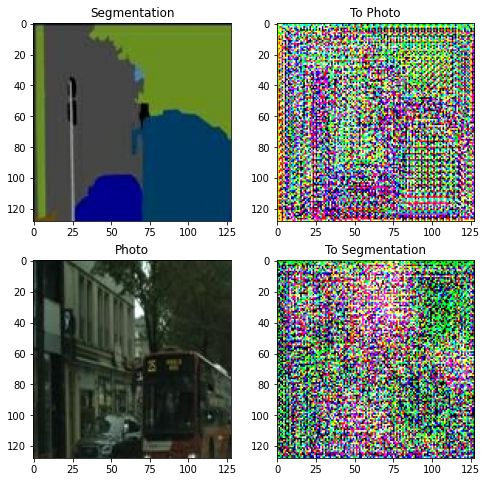

In [ ]:
to_seg = generator_g(sample_photo)
to_photo = generator_f(sample_seg)
plt.figure(figsize=(8, 8))

imgs = [sample_seg, to_photo, sample_photo, to_seg]
title = ["Segmentation", "To Photo", "Photo", "To Segmentation"]

for i in range(len(imgs)):
  plt.subplot(2,2, i+1)
  plt.title(title[i])
  if i % 2 ==0:
    plt.imshow(imgs[i][0]*0.5+0.5)
  else:
    plt.imshow(imgs[i][0]*0.5*contrast+0.5)
plt.show()

Testing out the discriminator on the sample data

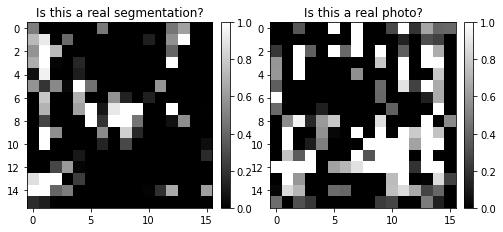

In [ ]:
plt.figure(figsize=(8, 8))
img = discriminator_y(sample_seg)[0,..., -1]
plt.subplot(121)
plt.title('Is this a real segmentation?')
plt.imshow(img, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
# where white indicates discriminator thinks it's a photo and Black/gray indicates the discriminator thinks it's not a photo
plt.clim(0, 1)

img = discriminator_x(sample_photo)[0,..., -1]
plt.subplot(122)
plt.title('Is this a real photo?')
plt.imshow(img, cmap='gray')
plt.colorbar(fraction=0.046, pad=0.04)
# where white indicates discriminator thinks it's a segmentaion and Black/gray indicates the discriminator thinks it's not a segmentation
plt.clim(0, 1)



In [ ]:
# discriminator loss
def discriminator_loss(real, generated):
  real_loss = tf.keras.losses.mean_squared_error(tf.ones_like(real), real)
  generated_loss = tf.keras.losses.mean_squared_error(tf.zeros_like(generated), generated)
  # total disc loss
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

In [ ]:
# generator loss
def generator_loss(generated):
  return tf.keras.losses.mean_squared_error(tf.ones_like(generated), generated)

# Training

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,1000)

In [ ]:
# image pool class that stores 50 previously generated images 
class ImagePool(object):
  def __init__(self, maxsize=50):
    self.maxsize = maxsize
    self.num_img = 0
    self.images = []

  def __call__(self, image):
    if self.maxsize <= 0:
      return image
    if self.num_img < self.maxsize:
       self.images.append(image)
       self.num_img += 1
       return image
    if np.random.rand() > 0.5:
       idx = int(np.random.rand()*self.maxsize)
       tmp1 = copy.copy(self.images[idx])[0]
       self.images[idx][0] = image[0]
       idx = int(np.random.rand()*self.maxsize)
       tmp2 = copy.copy(self.images[idx])[1]
       self.images[idx][1] = image[1]
       return [tmp1, tmp2]
    else:
      return image

# class that implements the CycleGAN Algorithm 
class CycleGan():
  def __init__(self, train_ds, steps,generator_g, generator_f, discriminator_x, discriminator_y,c_model_YtoX, c_model_XtoA,  sample_photo):
    self.generator_g = generator_g
    self.generator_f = generator_f
    self.discriminator_x = discriminator_x
    self.discriminator_y = discriminator_y
    self.sample_photo = sample_photo
    self.train_ds = train_ds
    self.steps = steps
    self.pool = ImagePool()
    self.c_model_YtoX = c_model_YtoX
    self.c_model_XtoA = c_model_XtoA
      
  # plotting method for the images
  def generate_images(self):
    prediction = self.generator_g(self.sample_photo)
    plt.figure(figsize=(12, 12))
    display_list = [self.sample_photo[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
      plt.subplot(1, 2, i+1)
      if i % 2 ==0:
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
      else:
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()

  # method that fits the model by calling the train step and saves the segmentation generator
  def fit(self):
    start = time.time()
    for step, (image_photo, image_seg) in self.train_ds.repeat().take(steps).enumerate():
      self.train_step(step, image_photo, image_seg)
      if step % 100:
        clear_output(wait=True)
        # Using a consistent image  so that the progress of the model
        # is clearly visible.
        self.generate_images()
        print ('Time taken for step {} is {} sec\n'.format(step + 1, time.time()-start))
    # saves the segmentation generator
    self.generator_g.save('/content/model/segmentation/')

  # returns real image and target
  def generate_real_samples(self, real):
    # generate 'real' class labels (1)
    y = tf.ones_like(real)
  	return  real, y

  # returns fake image and target
  def generate_fake_samples(self, g_model, real):
   # generate fake instance
	  X = g_model.predict(real)
	  # create 'fake' class labels (0)
	  y = tf.zeros_like(X)
	  return X, y

  # method that trains the generators and discriminators 
  def train_step(self,step,real_x, real_y):
      # select real samples
		  real_x, y_realx = self.generate_real_samples(real_x)
		  real_y, y_realy = self.generate_real_samples(real_y)
		  # generate a batch of fake samples
		  fake_x, y_fakex = self.generate_fake_samples(self.generator_f, real_y)
		  fake_y, y_fakey = self.generate_fake_samples(self.generator_x, real_x)
      # update fake image pool 
      [fake_y, fake_x] = self.pool([fake_y, fake_x])
      # update generator Y->X via adversarial and cycle loss
		  g_loss2, _, _, _, _  = self.c_model_YtoX.train_on_batch([real_y, real_x], [y_realx, real_x, real_y, real_x])
		  # update discriminator for X -> [real/fake]
		  dA_loss1 = self.discriminator_x.train_on_batch(real_x, y_realx)
		  dA_loss2 = self.discriminator_x.train_on_batch(fake_x, y_fakex)
		  # update generator X->Y via adversarial and cycle loss
		  g_loss1, _, _, _, _ = self.c_model_XtoA.train_on_batch([real_x, real_y], [y_realy, real_y, real_x, real_y])
		  # update discriminator for Y -> [real/fake]
		  dB_loss1 = self.discriminator_y.train_on_batch(real_y, y_realy)
		  dB_loss2 = self.discriminator_y.train_on_batch(fake_y, y_fakey)
		  # summarize performance
		  print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (step+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
      

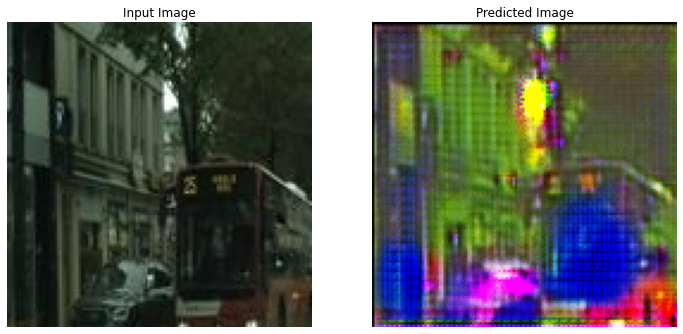

Time taken for step 8268 is 12439.203497171402 sec



In [ ]:
# define properties of the training run
n_epochs, n_batch = 1, 1
# calculate the number of batches per training epoch
bat_per_epo = int(2975/n_batch)
# calculate the number of training iterations
steps = bat_per_epo * n_epochs
# creating the CycleGAN object and fitting the model
x=CycleGan(train_ds, steps,generator_g, generator_f, discriminator_x, discriminator_y,c_model_YtoX, c_model_XtoA, sample_photo)
x.fit()

In [ ]:
def generate_images(model, test):
    prediction = model(test)
    plt.figure(figsize=(12, 12))
    display_list = [test[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
      plt.subplot(1, 2, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()

for inp in test_photo.take(5):
  generate_images(generator_g, inp)